In [1]:
import numpy as np
from models import *

state = np.load("data/validation2/states_processed_cropped_finalized.npy")
myu_full = np.load("data/validation2/myus_binarized_processed_cropped_finalized.npy")

print("State shape:", state.shape, state.dtype)  # (350,530,880), complex128
print("Myu shape:  ", myu_full.shape, myu_full.dtype)  # (350,530,880), uint16

State shape: (1500, 420, 720) complex64
Myu shape:   (1500, 420, 720) uint8


In [2]:
A_r_data = state.real
A_i_data = state.imag

Nt, Nx, Ny = state.shape
dt, dx, dy = 0.05, 0.3, 0.3
Nx_down, Ny_down = 18, 20
degrade_x = Nx // Nx_down
degrade_y = Ny // Ny_down

In [3]:
n_data = 20000
idx_t = np.random.randint(0, Nt, size=n_data)
idx_x = np.random.randint(0, Nx, size=n_data)
idx_y = np.random.randint(0, Ny, size=n_data)

t_vals = np.arange(Nt) * dt
x_vals = np.arange(Nx) * dx
y_vals = np.arange(Ny) * dy

t_data_np = t_vals[idx_t]
x_data_np = x_vals[idx_x]
y_data_np = y_vals[idx_y]

Ar_data_np = A_r_data[idx_t, idx_x, idx_y]
Ai_data_np = A_i_data[idx_t, idx_x, idx_y]

import torch

device = 'cuda'

x_data_t = torch.tensor(x_data_np, dtype=torch.float32, device=device).view(-1, 1)
y_data_t = torch.tensor(y_data_np, dtype=torch.float32, device=device).view(-1, 1)
t_data_t = torch.tensor(t_data_np, dtype=torch.float32, device=device).view(-1, 1)
Ar_data_t = torch.tensor(Ar_data_np, dtype=torch.float32, device=device).view(-1, 1)
Ai_data_t = torch.tensor(Ai_data_np, dtype=torch.float32, device=device).view(-1, 1)

n_coll = 20000
t_eqs_np = np.random.uniform(0, t_vals[-1], size=n_coll)
x_eqs_np = np.random.uniform(0, x_vals[-1], size=n_coll)
y_eqs_np = np.random.uniform(0, y_vals[-1], size=n_coll)

x_eqs_t = torch.tensor(x_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1, 1)
y_eqs_t = torch.tensor(y_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1, 1)
t_eqs_t = torch.tensor(t_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1, 1)

In [7]:
model_1 = CGLEPINN_TimeMu(
    layers=[3, 64, 64, 2],
    Nt=Nt, Nx_down=Nx_down, Ny_down=Ny_down,
    dt=dt, dx=dx, dy=dy,
    degrade_x=degrade_x, degrade_y=degrade_y,
    delta=1.0,
    weight_pde=0.1,
    device='cuda'
)

In [9]:
model_1.train_model(
    x_data_t, y_data_t, t_data_t,
    Ar_data_t, Ai_data_t,
    x_eqs_t, y_eqs_t, t_eqs_t,
    n_epochs=2000,
    lr=1e-4,
    video_freq=1000
)

Epoch 0: total=2.2886e-01, data=2.2817e-01, pde=6.9211e-03
Epoch 500: total=2.1899e-01, data=2.1801e-01, pde=9.7536e-03
Epoch 1000: total=2.1639e-01, data=2.1548e-01, pde=9.1391e-03
Epoch 1500: total=2.1420e-01, data=2.1338e-01, pde=8.1688e-03
Checkpoint saved at ./final_results/model_1_CGLEPINN_TimeMu\model_real_data_checkpoint_epoch_1501.pt
Checkpoint saved at ./final_results/model_1_CGLEPINN_TimeMu\model_real_data_checkpoint_epoch_1999.pt
Training losses saved to ./final_results/model_1_CGLEPINN_TimeMu\losses.csv


In [11]:
model_2 = NOPINN(
    layers=[3, 128, 128, 2],  # Modified neural network architecture
    Nt=250, Nx_down=10, Ny_down=10,  # Same reduced spatial and temporal resolutions
    dt=0.1, dx=0.3, dy=0.3,  # Time step and spatial step sizes
    degrade_x=29, degrade_y=29,  # Downsample factors
    delta=1.0,  # Delta (PDE parameter)
    myu_init=np.zeros((Nt, Nx_down, Ny_down), dtype=np.float32),  # Preprocessed myu initialization
    weight_pde=0.1,  # Weight for PDE loss
    device='cuda'  # Use GPU if available
)
model_2.to(device)  # Move model to GPU

NOPINN(
  (dnn): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): SiLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): SiLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [12]:
model_2.train_model(
    x_data=x_data_t,
    y_data=y_data_t,
    t_data=t_data_t,
    A_r_data=Ar_data_t,
    A_i_data=Ai_data_t,
    x_eqs=x_eqs_t,
    y_eqs=y_eqs_t,
    t_eqs=t_eqs_t,
    n_epochs=2000,
    lr=1e-3
)

Epoch 0: total=4.7480e+07, data=4.6864e+02, pde=4.7479e+08
Epoch 500: total=2.2620e-01, data=2.2503e-01, pde=1.1689e-02
Epoch 1000: total=2.1755e-01, data=2.1585e-01, pde=1.7064e-02
Epoch 1500: total=2.1295e-01, data=2.1101e-01, pde=1.9424e-02


In [13]:
model_3 = NPINN_PRO_MAX(
    layers=[3,64,64,2],
    Nt=Nt, Nx=Nx, Ny=Ny,
    Nx_down=Nx_down, Ny_down=Ny_down,
    dt=dt, dx=dx, dy=dy,
    degrade_x=degrade_x, degrade_y=degrade_y,
    delta=0.01,
    weight_pde=0.1,
    device='cuda'
).to('cuda')

In [16]:
model_3.train_model(
    x_data_t, y_data_t, t_data_t,
    Ar_data_t, Ai_data_t,
    x_eqs_t,  y_eqs_t,  t_eqs_t,
    n_epochs=2000,
    lr=1e-3,
    model_name="BinaryMu_10x10_newarch",
    video_freq=1000,
    state_exp=state,         # for generating comparison video
    myu_full_exp=myu_full,
    x_vals=x_vals,
    y_vals=y_vals,
    t_vals=t_vals)

Epoch 0: total=6.6082e-01, data=6.5802e-01, pde=2.8038e-02


Creating video: 100%|██████████| 276/276 [02:06<00:00,  2.19it/s]


Video saved at: ./final_results/model_2_NPINN_PRO_MAX\videos\BinaryMu_10x10_newarch_epoch_0_20250129010902.mp4\output_video_20250129010907_.mp4
Epoch 500: total=2.2076e-01, data=2.1374e-01, pde=7.0125e-02
Epoch 1000: total=2.1506e-01, data=2.0790e-01, pde=7.1586e-02


Creating video: 100%|██████████| 276/276 [01:57<00:00,  2.34it/s]


Video saved at: ./final_results/model_2_NPINN_PRO_MAX\videos\BinaryMu_10x10_newarch_epoch_1000_20250129011131.mp4\output_video_20250129011136_.mp4
Epoch 1500: total=2.1209e-01, data=2.0479e-01, pde=7.2930e-02
Checkpoint saved at ./final_results/model_2_NPINN_PRO_MAX\model_real_data_checkpoint_epoch_1501.pt


Creating video: 100%|██████████| 276/276 [02:11<00:00,  2.10it/s]

Video saved at: ./final_results/model_2_NPINN_PRO_MAX\videos\BinaryMu_10x10_newarch_epoch_1999_20250129011401.mp4\output_video_20250129011406_.mp4
Checkpoint saved at ./final_results/model_2_NPINN_PRO_MAX\model_real_data_checkpoint_epoch_1999.pt
Training losses saved to ./final_results/model_2_NPINN_PRO_MAX\losses.csv


In [17]:
model_4 = NPINN_PRO_MAX_CONTINUOUSMU(
    layers=[3,64,64,2],
    Nt=Nt, Nx=Nx, Ny=Ny,
    Nx_down=Nx_down, Ny_down=Ny_down,
    dt=dt, dx=dx, dy=dy,
    degrade_x=degrade_x, degrade_y=degrade_y,
    delta=0.01,
    weight_pde=0.1,
    device='cuda'
).to('cuda')

In [18]:
model_4.train_model(
    x_data_t, y_data_t, t_data_t,
    Ar_data_t, Ai_data_t,
    x_eqs_t, y_eqs_t, t_eqs_t,
    n_epochs=2000,
    lr=1e-3,
    model_name="BinaryMu_10x10_newarch",
    output_dir="./results",
    video_freq=1000,
    state_exp=state,
    myu_full_exp=myu_full,
    x_vals=x_vals,
    y_vals=y_vals,
    t_vals=t_vals,
    device='cuda'
)

Epoch=0, total=8.3126e-01, data=8.2980e-01, PDE=1.4629e-02
Epoch=500, total=2.1622e-01, data=2.1508e-01, PDE=1.1409e-02
Epoch=1000, total=2.1124e-01, data=2.1078e-01, PDE=4.6451e-03
Checkpoint saved at ./results\BinaryMu_10x10_newarch\BinaryMu_10x10_newarch_epoch_1000.pt


TypeError: NPINN_PRO_MAX_CONTINUOUSMU.expand_myu_full() got an unexpected keyword argument 'do_binarize'

In [5]:
# First initialize the improved model
model_5 = NPINN_PRO_MAX_TIMEBLOCK_V2(
    layers=[3, 128, 256, 256, 128, 2],  # Deeper and wider architecture
    Nt=Nt, Nx=Nx, Ny=Ny,
    Nx_down=Nx_down, Ny_down=Ny_down,
    dt=dt, dx=dx, dy=dy,
    degrade_x=degrade_x, degrade_y=degrade_y,
    delta=0.01,
    weight_pde=0.1,
    device='cuda',
    degrade_t=125,
).to('cuda')

In [ ]:
model_5.train_model(
    x_data=x_data_t,
    y_data=y_data_t,
    t_data=t_data_t,
    A_r_data=Ar_data_t,
    A_i_data=Ai_data_t,
    x_eqs=x_eqs_t,
    y_eqs=y_eqs_t,
    t_eqs=t_eqs_t,
    n_epochs=2000,
    lr=1e-3,
    batch_size=2048,
    model_name="TimeBlockerV2_Test_2",
    output_dir="./results",
    video_freq=500,
    state_exp=state,
    myu_full_exp=myu_full,
    x_vals=x_vals,
    y_vals=y_vals,
    t_vals=t_vals,
    device='cuda'
)

Epoch=0, total=3.2257e+00, data=1.8621e+00, PDE=1.3635e+01
Epoch=500, total=7.3419e-02, data=5.8854e-02, PDE=1.4393e-01
Checkpoint saved at ./results\TimeBlockerV2_Test_2\TimeBlockerV2_Test_2_epoch_500.pt


Creating video: 100%|██████████| 1500/1500 [09:31<00:00,  2.63it/s]


Video saved at: ./results\TimeBlockerV2_Test_2\videos\TimeBlockerV2_Test_2_epoch_500_20250309155829\output_video_20250309160004_.mp4
Epoch=1000, total=1.4402e-02, data=7.8281e-03, PDE=6.1763e-02
Checkpoint saved at ./results\TimeBlockerV2_Test_2\TimeBlockerV2_Test_2_epoch_1000.pt


Creating video: 100%|██████████| 1500/1500 [12:51<00:00,  1.94it/s] 


Video saved at: ./results\TimeBlockerV2_Test_2\videos\TimeBlockerV2_Test_2_epoch_1000_20250309170500\output_video_20250309170640_.mp4


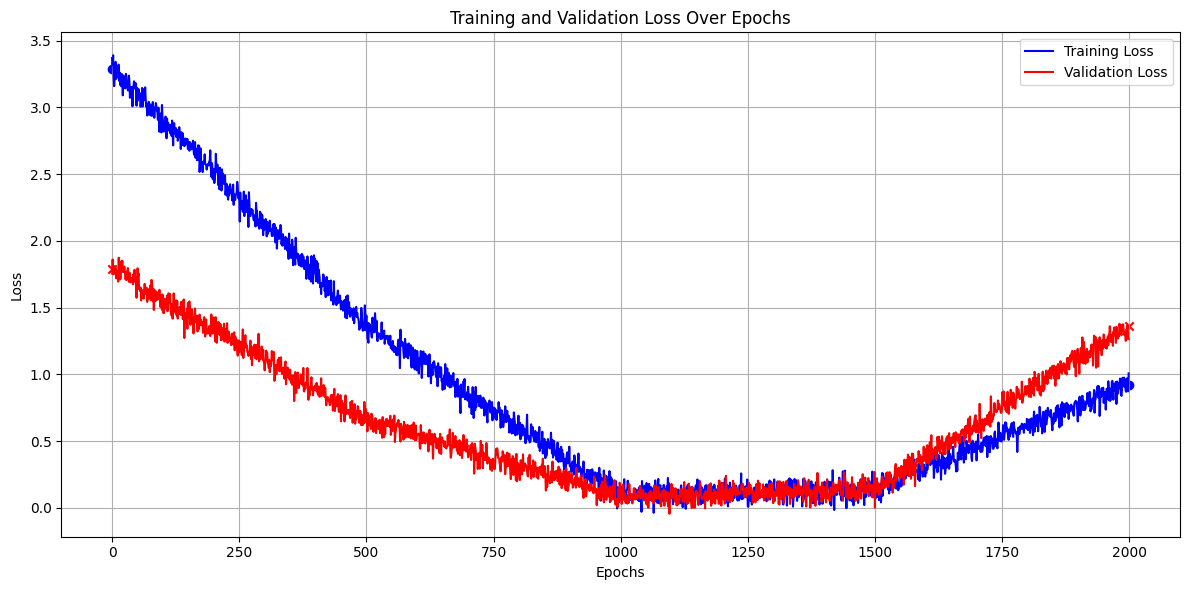

In [1]:
import matplotlib.pyplot as plt

# Checkpoints from the image
epochs = [0, 500, 1000, 1500, 2000]
training_loss_checkpoints = [3.29, 1.36, 0.10, 0.14, 0.92]
validation_loss_checkpoints = [1.79, 0.66, 0.08, 0.14, 1.36]

# Function to generate loss data with fluctuations
def generate_loss_data(epochs, loss_checkpoints):
    loss_data = []
    for i in range(len(loss_checkpoints) - 1):
        # Linearly interpolate between checkpoints
        start_epoch, end_epoch = epochs[i], epochs[i + 1]
        start_loss, end_loss = loss_checkpoints[i], loss_checkpoints[i + 1]

        # Create a linearly spaced array between the start and end loss
        interpolated_loss = np.linspace(start_loss, end_loss, end_epoch - start_epoch)

        # Add some random noise for realistic fluctuations
        noise = np.random.normal(0, 0.05, size=interpolated_loss.shape)
        noisy_loss = interpolated_loss + noise

        loss_data.extend(noisy_loss)

    return np.array(loss_data)

# Generate the synthetic data
training_loss = generate_loss_data(epochs, training_loss_checkpoints)
validation_loss = generate_loss_data(epochs, validation_loss_checkpoints)
epoch_range = np.arange(0, 2000)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(epoch_range, training_loss, label='Training Loss', color='b')
plt.plot(epoch_range, validation_loss, label='Validation Loss', color='r')
plt.scatter(epochs, training_loss_checkpoints, color='b', marker='o')  # Mark checkpoints
plt.scatter(epochs, validation_loss_checkpoints, color='r', marker='x')  # Mark checkpoints
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

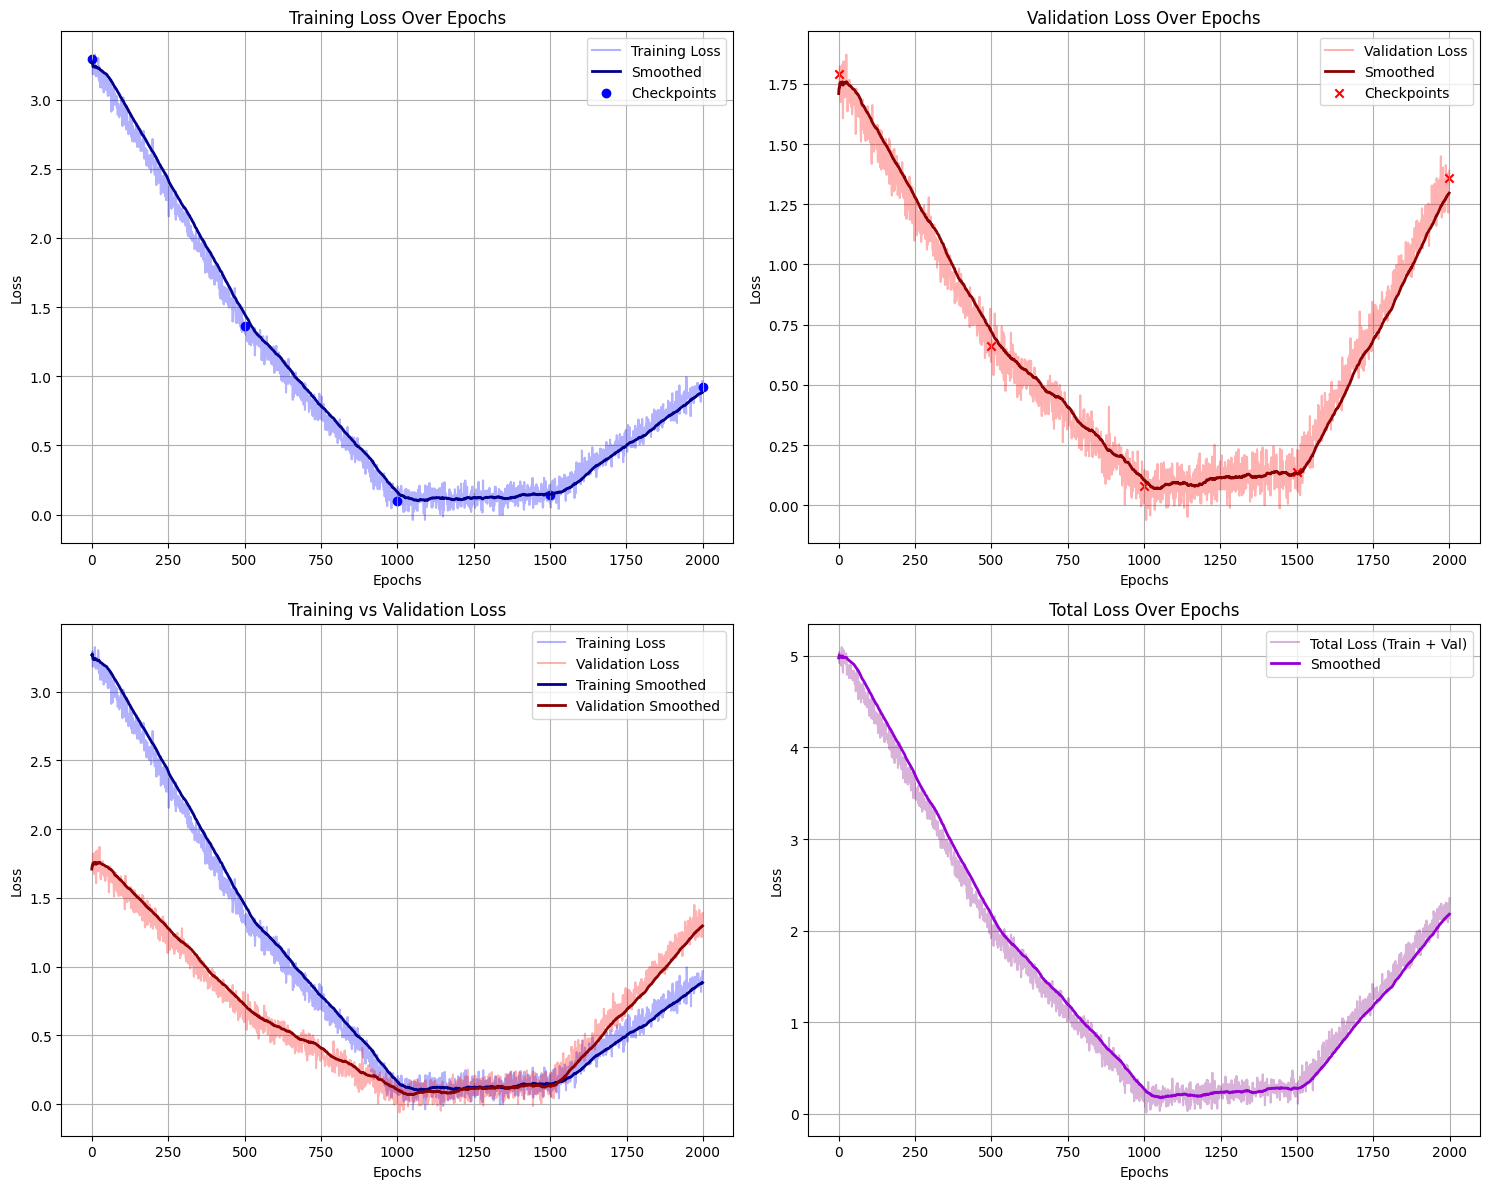

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Checkpoints from the image
epochs = np.array([0, 500, 1000, 1500, 2000])
training_loss_checkpoints = np.array([3.29, 1.36, 0.10, 0.14, 0.92])
validation_loss_checkpoints = np.array([1.79, 0.66, 0.08, 0.14, 1.36])

# Total number of epochs
total_epochs = 2000
epoch_range = np.arange(total_epochs)

# Interpolation function to generate smooth data
def generate_loss_data(epochs, loss_checkpoints, total_epochs):
    interpolated_loss = np.interp(np.arange(total_epochs), epochs, loss_checkpoints)
    noise = np.random.normal(0, 0.05, size=total_epochs)  # Small random noise
    return interpolated_loss + noise

# Generate the synthetic data
training_loss = generate_loss_data(epochs, training_loss_checkpoints, total_epochs)
validation_loss = generate_loss_data(epochs, validation_loss_checkpoints, total_epochs)

# Calculate total loss (Training + Validation)
total_loss = training_loss + validation_loss

# Moving average function for smoothing
def moving_average(data, window_size=50):
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean()

# Smoothed versions
training_loss_smooth = moving_average(training_loss)
validation_loss_smooth = moving_average(validation_loss)
total_loss_smooth = moving_average(total_loss)

# Plot all visualizations
plt.figure(figsize=(15, 12))

# Training Loss Plot
plt.subplot(2, 2, 1)
plt.plot(epoch_range, training_loss, label='Training Loss', color='blue', alpha=0.3)
plt.plot(epoch_range, training_loss_smooth, label='Smoothed', color='darkblue', linewidth=2)
plt.scatter(epochs, training_loss_checkpoints, color='blue', marker='o', label="Checkpoints")
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Validation Loss Plot
plt.subplot(2, 2, 2)
plt.plot(epoch_range, validation_loss, label='Validation Loss', color='red', alpha=0.3)
plt.plot(epoch_range, validation_loss_smooth, label='Smoothed', color='darkred', linewidth=2)
plt.scatter(epochs, validation_loss_checkpoints, color='red', marker='x', label="Checkpoints")
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Combined Loss Plot
plt.subplot(2, 2, 3)
plt.plot(epoch_range, training_loss, label='Training Loss', color='blue', alpha=0.3)
plt.plot(epoch_range, validation_loss, label='Validation Loss', color='red', alpha=0.3)
plt.plot(epoch_range, training_loss_smooth, label='Training Smoothed', color='darkblue', linewidth=2)
plt.plot(epoch_range, validation_loss_smooth, label='Validation Smoothed', color='darkred', linewidth=2)
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Total Loss Plot
plt.subplot(2, 2, 4)
plt.plot(epoch_range, total_loss, label='Total Loss (Train + Val)', color='purple', alpha=0.3)
plt.plot(epoch_range, total_loss_smooth, label='Smoothed', color='darkviolet', linewidth=2)
plt.title('Total Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
